In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import sys

sys.path.append('../')
from ConformalMethods import AdaptiveCP, ACP_data, ACP_plots

We want to create a dtaci equivilent where we run multiple dtaci in parrelel with different lookbacks and then choose the most suitable ones. Need to have some form of modular head, which is a generator for the coverage window, then will simply use the l1 loss for a reweighting scheme and you will likley have a scale which you will eventually have to find. 

In [4]:
def C_t(self, alpha_t, scores, x_t, t, custom_interval = None):
    interval = custom_interval if custom_interval is not None else self.interval_size
    assert interval < len(scores), 'Attempting to look back further than is possible.'
    
    # Insuring that alpha_t is between 0 and 1
    alpha_t = min(1, max(0, alpha_t))
    
    Q = np.quantile(scores[t-interval:t], 1 - alpha_t)
    positve_v = self.pos_inverse_score(x_t, Q)
    negative_v = self.neg_inverse_score(x_t, Q)
    
    return negative_v, positve_v

@staticmethod
def err_t(y_t, C_t_interval):
    if C_t_interval[0] < y_t < C_t_interval[1]:
        return 0
    else:
        return 1
    
def l(self, B, theta):
    return (self.coverage_target * (B - theta)) - min(0, (B - theta))

def vectorize_l(self):
    return np.vectorize(self.l)

In [5]:
class AwDtAci_place(AdaptiveCP):
    def __init__(self, coverage):
        self.coverage_target = coverage
        self.interval_size = 50
        self.score_function = lambda xpred, y: (abs(y - xpred))/abs(xpred)
        self.neg_inverse_score =  lambda x_t, Q: (x_t) - (abs(x_t) * Q)
        self.pos_inverse_score = lambda x_t, Q: (x_t) + (abs(x_t) * Q)

    def DtACI_head(self, timeseries_data: tuple, custom_interval: int = None, start_point: int = None, gamma_candidates: np.array = None,  title: str = None):
        '''start_point: The value which the head will start calculating from'''
        xpred, y = timeseries_data
        if gamma_candidates is None:
            gamma_candidates = np.array([0.001, 0.004, 0.032, 0.064, 0.128, 0.256, 0.512])

        # we need a vectorised version of l
        l_vec = self.vectorize_l()
        
        candiate_alpha = np.array([[self.coverage_target for _ in gamma_candidates]])
        gamma_weights = np.array([1 for _ in gamma_candidates])
        
        chosen_gamma_index = []
        err_t_list = []
        conformal_sets_list = []
        alpha_t_list = []
        alpha_error_list = []
        B_t_list = []
        
        # sigma = 1/(2*custom_interval)
        # nu = np.sqrt((3/custom_interval) * (np.log(len(gamma_candidates)*custom_interval) + 2)/((1-self.coverage_target)**2 * self.coverage_target**2))

        sigma = 1/(2*self.interval_size)
        nu = np.sqrt((3/self.interval_size) * (np.log(len(gamma_candidates)*self.interval_size) + 2)/((1-self.coverage_target)**2 * self.coverage_target**2))
        
        # Calculating the scores at each time step
        All_scores = self.score_function(xpred, y)

        for i in range(start_point, len(All_scores)):
            # Calcualting the probability of each gamma from the weights from step t-1.
            Wt = gamma_weights.sum()
            gamma_probabilites = gamma_weights/Wt
            
            # Choosing a alpha from the probabilites from the gamma candidates.
            chosen_alpha_t = np.random.choice(candiate_alpha[-1], p=gamma_probabilites)
            alpha_t_list.append(chosen_alpha_t)
            candiate_alpha_index = np.where(candiate_alpha[-1] == chosen_alpha_t)[0][0]
            chosen_gamma_index.append(candiate_alpha_index)

            Coverage_t = self.C_t(chosen_alpha_t, All_scores, xpred[i], i, custom_interval)
            conformal_sets_list.append(Coverage_t)

            # Yield the conformal set
            yield Coverage_t
            
            err_true = AdaptiveCP.err_t(y[i], Coverage_t)
            err_t_list.append(err_true)

            # TIME FRONTIER -------

            # Smallest interval containg the true value.
            #B_t = 0.5       # To avoid unbound local error will assign B_t a value first
            for possi in np.linspace(1, 0, 1000):
                Cpossi= self.C_t(possi, All_scores, xpred[i], i)
                if Cpossi[0] < y[i] < Cpossi[1]:
                    B_t = possi
                    break
            
            B_t_list.append(B_t)
            
            # Updating the weights.
            new_weights = gamma_weights * np.exp(-nu * l_vec(B_t, candiate_alpha[-1]))
            
            sumW, lenW = sum(new_weights), len(new_weights)
            final_weights = new_weights*(1-sigma) + sumW*(sigma/lenW)
            gamma_weights = final_weights

            # Calculating the coverage and error at each time step, for different alpha values.
            alphai_errors = np.array([AdaptiveCP.err_t(y[i], self.C_t(alpha_i, All_scores, xpred[i], i)) for alpha_i in candiate_alpha[-1]])
            alpha_error_list.append(alphai_errors)

            # Updating the alpha values.
            new_alphas = candiate_alpha[-1] + (gamma_candidates * (self.coverage_target - alphai_errors))
            candiate_alpha = np.vstack((candiate_alpha, new_alphas))
        
        print(B_t_list)
        return False



In [101]:
class test(AdaptiveCP):
    def __init__(self):
        self.interval_size = 50
        self.coverage_target = 0.3

    def AwDtAci(self, timeseries_data: tuple, interval_candidates: np.array = None, title: str = None):
        xpred, y = timeseries_data
        chosen_interval_index = []
        err_t_list = []
        conformal_sets_list = []

        if interval_candidates is None:
            interval_candidates = np.array(range(25, 300, 25))

        # To sync all of the heads we need to start at the max of all the candidates.
        start_point = max(interval_candidates) + 1

        # Create the head and intitialse the weights.
        AwDtAci_place_instance = AwDtAci_place(0.1)
        DtACI_heads = [AwDtAci_place_instance.DtACI_head(timeseries_data, interval, start_point) for interval in interval_candidates]
        interval_weights = np.array([1 for _ in range(len(interval_candidates))])

        # Scaling the parameters, there is no way these are the best ways.
        sigma = 1/(2*self.interval_size)
        nu = 10**-3 # needs to be at least minus two for anything to work.
        
        l_vec = self.vectorize_l()

        none_terminated = True
        i_count = start_point
        
        while none_terminated: # Continues calculating intervals until one of the heads stops.
            head_sets = []
            
            # Create the mass distribution for each head
            Wt = interval_weights.sum()
            interval_probabilites = interval_weights/Wt
            #print(interval_probabilites)
        
            # Create a list of the coverages for the different heads.
            try:
                for head in DtACI_heads:
                        head_sets.append(next(head))
            
            except StopIteration: # The head is terminated.
                none_terminated = False
                break # You could but the return statement here

            # Choosing which head to use.
            chosen_set = random.choices(head_sets, weights=interval_probabilites, k=1)[0] # Using random module as numpy can not deal with tuples.
            conformal_sets_list.append(chosen_set)
            chosen_interval_index.append(head_sets.index(chosen_set))

            # TIME FRONTIER -------------

            # Seeing whether result lies within the set.
            err_true = AdaptiveCP.err_t(y[i_count], chosen_set)
            err_t_list.append(err_true)

            # Finding the best possible set. 
            optimal_set_radius = xpred[i_count] - xpred[i_count-1]
            head_set_radius = list(map(lambda Cset: (Cset[1] - Cset[0])/2, head_sets)) #(chosen_set[1] - chosen_set[0])/2
            
            #l1_error = abs(optimal_set_radius - np.array(head_set_radius))
            head_set_radius = np.array(head_set_radius)
            #l1_error = (self.coverage_target * (optimal_set_radius - head_set_radius)) - min(0, (optimal_set_radius - head_set_radius))
            l1_error = l_vec(optimal_set_radius, head_set_radius)

            # Updating the weights.
            new_weights = interval_weights * np.exp( nu * l1_error ) # Removed negative from previous paper.
            
            sumW, lenW = sum(new_weights), len(new_weights)
            final_weights = new_weights*(1-sigma) + sumW*(sigma/lenW)
            #print(final_weights)
            interval_weights = final_weights
        # Here we have terminated

        # Calculating different averages
        realised_interval_coverage = 1 - pd.Series(err_t_list).rolling(50).mean().mean() # 50 is arbitary and could be improved.
        average_prediction_interval = np.mean([abs(x[1] - x[0]) for x in conformal_sets_list])

        return {
                'model': title if title is not None else 'AwDtACI',
                'coverage_target': self.coverage_target,
                'interval_candidates': interval_candidates,
                'realised_interval_coverage': realised_interval_coverage,
                'average_prediction_interval': average_prediction_interval,
                'conformal_sets': conformal_sets_list,
                'error_t_list': err_t_list,
                'chosen_interval_index': chosen_interval_index,
                'interval_size': 50
            }

In [102]:
single_shift = ACP_data.single_shift(seq_length=750)[0]

In [103]:
t = test()
result = t.AwDtAci(single_shift, [50, 100])

[np.float64(0.36436436436436437), np.float64(0.0830830830830831), np.float64(0.5005005005005005), np.float64(0.5535535535535536), np.float64(0.12612612612612617), np.float64(0.2842842842842843), np.float64(0.9059059059059059), np.float64(0.9259259259259259), np.float64(0.9459459459459459), np.float64(0.8478478478478478), np.float64(0.6646646646646647), np.float64(0.23123123123123124), np.float64(0.8308308308308309), np.float64(0.39539539539539537), np.float64(0.012012012012012074), np.float64(0.972972972972973), np.float64(0.5745745745745745), np.float64(0.7627627627627628), np.float64(0.9099099099099099), np.float64(0.4914914914914915), np.float64(0.3673673673673674), np.float64(0.0470470470470471), np.float64(0.7427427427427428), np.float64(0.4144144144144144), np.float64(0.5315315315315315), np.float64(0.16316316316316315), np.float64(1.0), np.float64(0.9269269269269269), np.float64(0.9279279279279279), np.float64(0.6796796796796797), np.float64(0.17717717717717718), np.float64(0.18

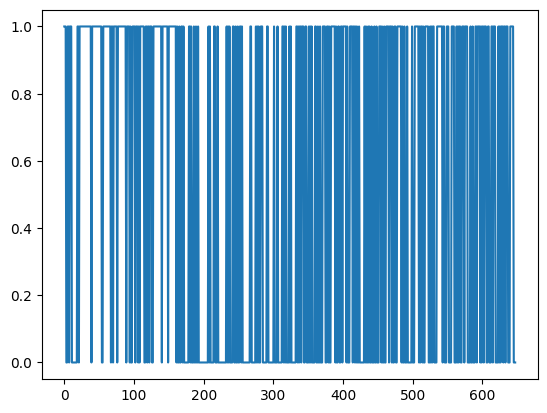

In [104]:
plt.plot(result['chosen_interval_index'])
plt.show()

Going to now run a lot of dtaci ones, my heads do not seem to be performing very well at all which suggests that there is an error somewhere.

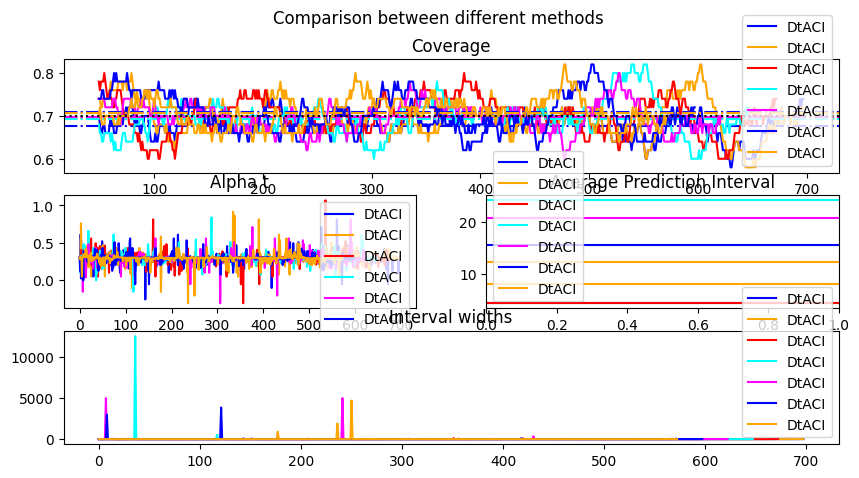

In [105]:
ACP = AdaptiveCP(0.3)
heads = [ACP.DtACI(single_shift, custom_interval=interval) for interval in range(25, 200, 25)]
ACP_plots.compare_many(heads)

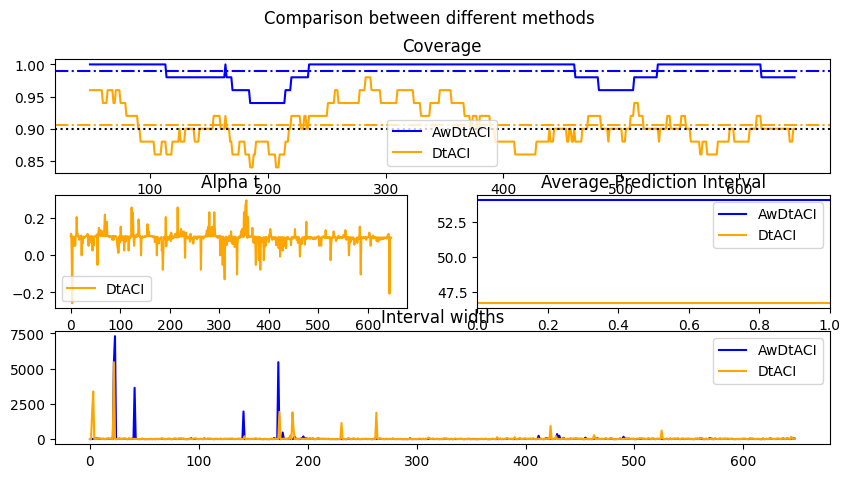

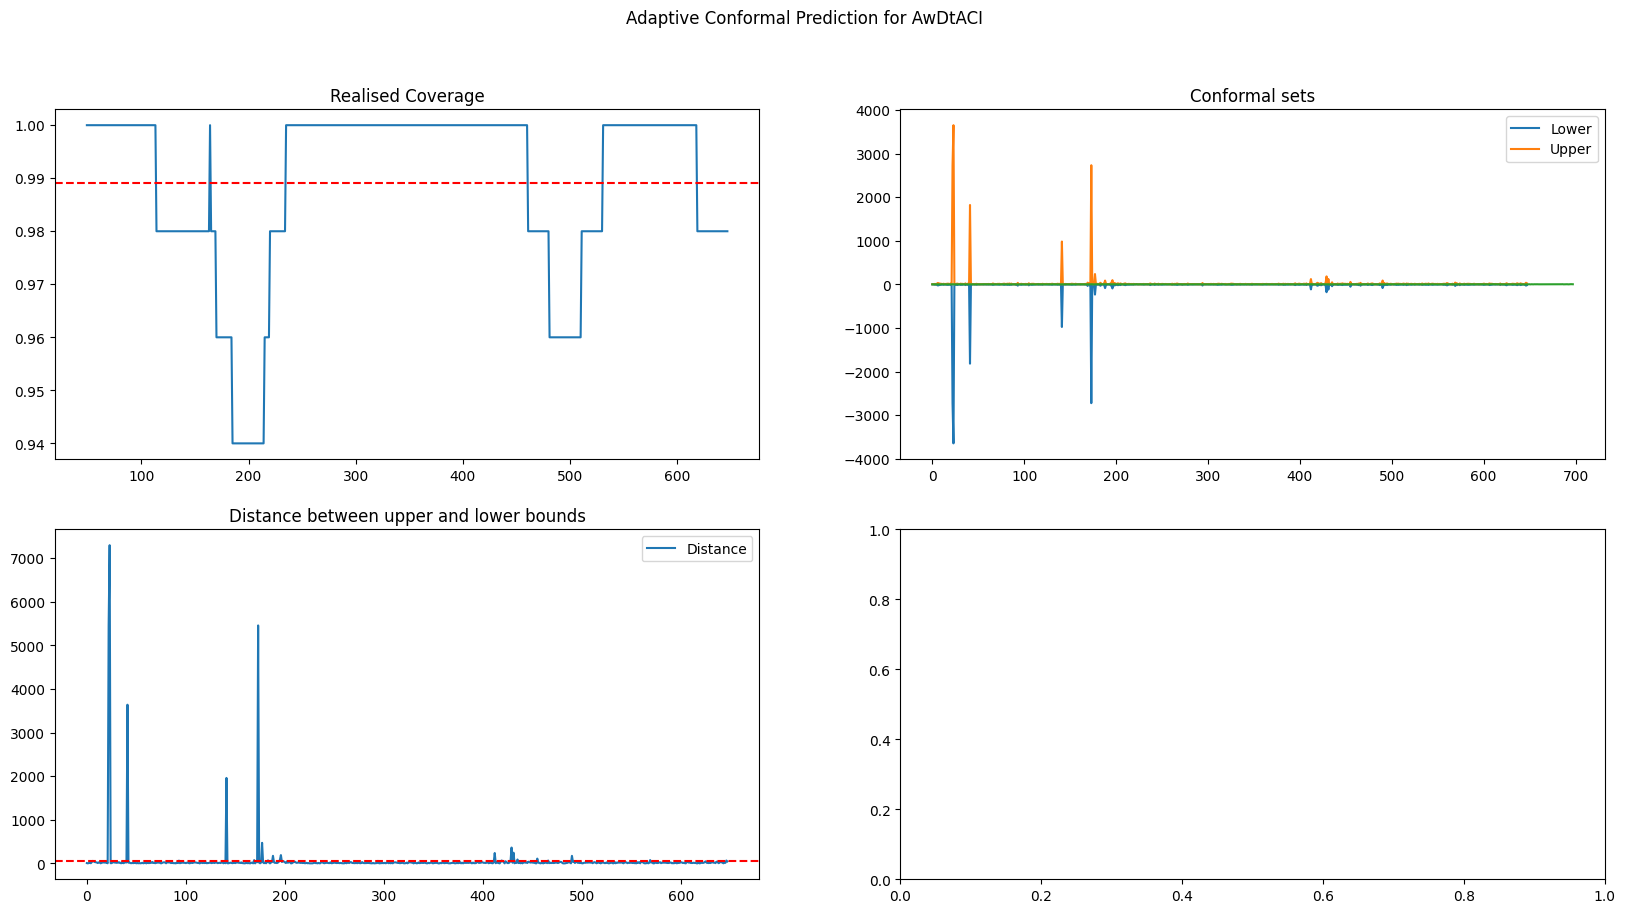

In [106]:
ACP = AdaptiveCP(0.1)
ACP_plots.compare_many([result, ACP.DtACI(single_shift, custom_interval=100)])
ACP_plots.one_plot(result, single_shift[1])

In [107]:
random_shift = ACP_data.random_multi_shift(1, (1000,1001))[0]
random_result = t.AwDtAci(random_shift)

[np.float64(0.3413413413413413), np.float64(1.0), np.float64(0.6736736736736737), np.float64(0.32932932932932935), np.float64(0.4194194194194194), np.float64(0.004004004004004025), np.float64(0.7457457457457457), np.float64(0.7197197197197197), np.float64(0.7177177177177176), np.float64(0.7267267267267268), np.float64(0.5975975975975976), np.float64(0.2842842842842843), np.float64(0.3733733733733734), np.float64(0.15915915915915912), np.float64(0.4054054054054054), np.float64(0.7027027027027026), np.float64(0.12812812812812813), np.float64(0.32832832832832837), np.float64(0.6856856856856857), np.float64(0.24124124124124124), np.float64(0.7097097097097097), np.float64(0.08008008008008005), np.float64(0.8828828828828829), np.float64(0.6396396396396397), np.float64(0.4604604604604605), np.float64(0.019019019019019034), np.float64(0.8168168168168168), np.float64(0.5185185185185186), np.float64(0.09109109109109115), np.float64(0.1291291291291291), np.float64(0.09809809809809811), np.float64

I think that the l1 loss between the smallest interval radius and the best radius is not the correct thing to measure, we should be penanlising the greater and smaller by different amounts. Thinking anout this there is nothing to stop us from doing this. We could penalise and over cover by different amounts and then we could have that the thing goes both up and down. This could also potentialy stop the error getting too large. 

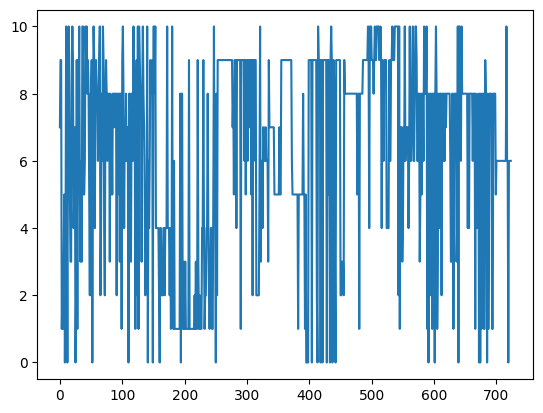

In [109]:
plt.plot(random_result['chosen_interval_index'])
plt.show()

In [1]:
ACP = AdaptiveCP(0.1)
ACP_plots.compare_many([random_result, ACP.ACI(random_shift, 0.05)])
ACP_plots.one_plot(random_result, random_shift[1])

NameError: name 'AdaptiveCP' is not defined

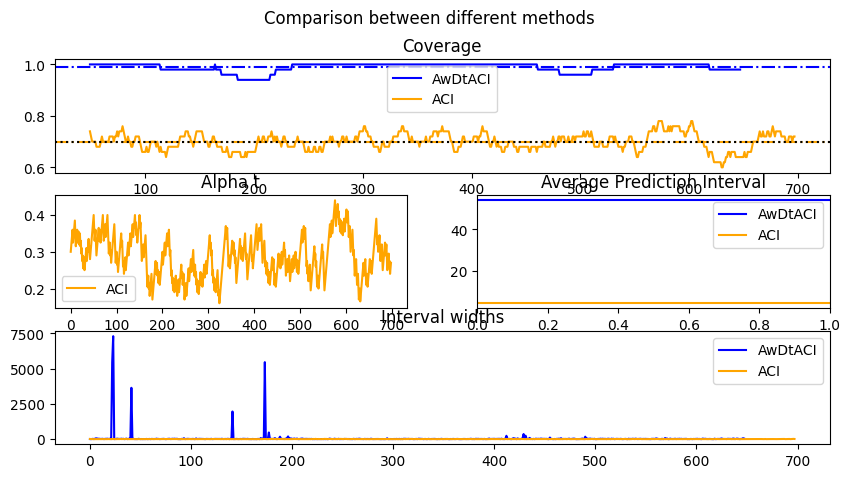

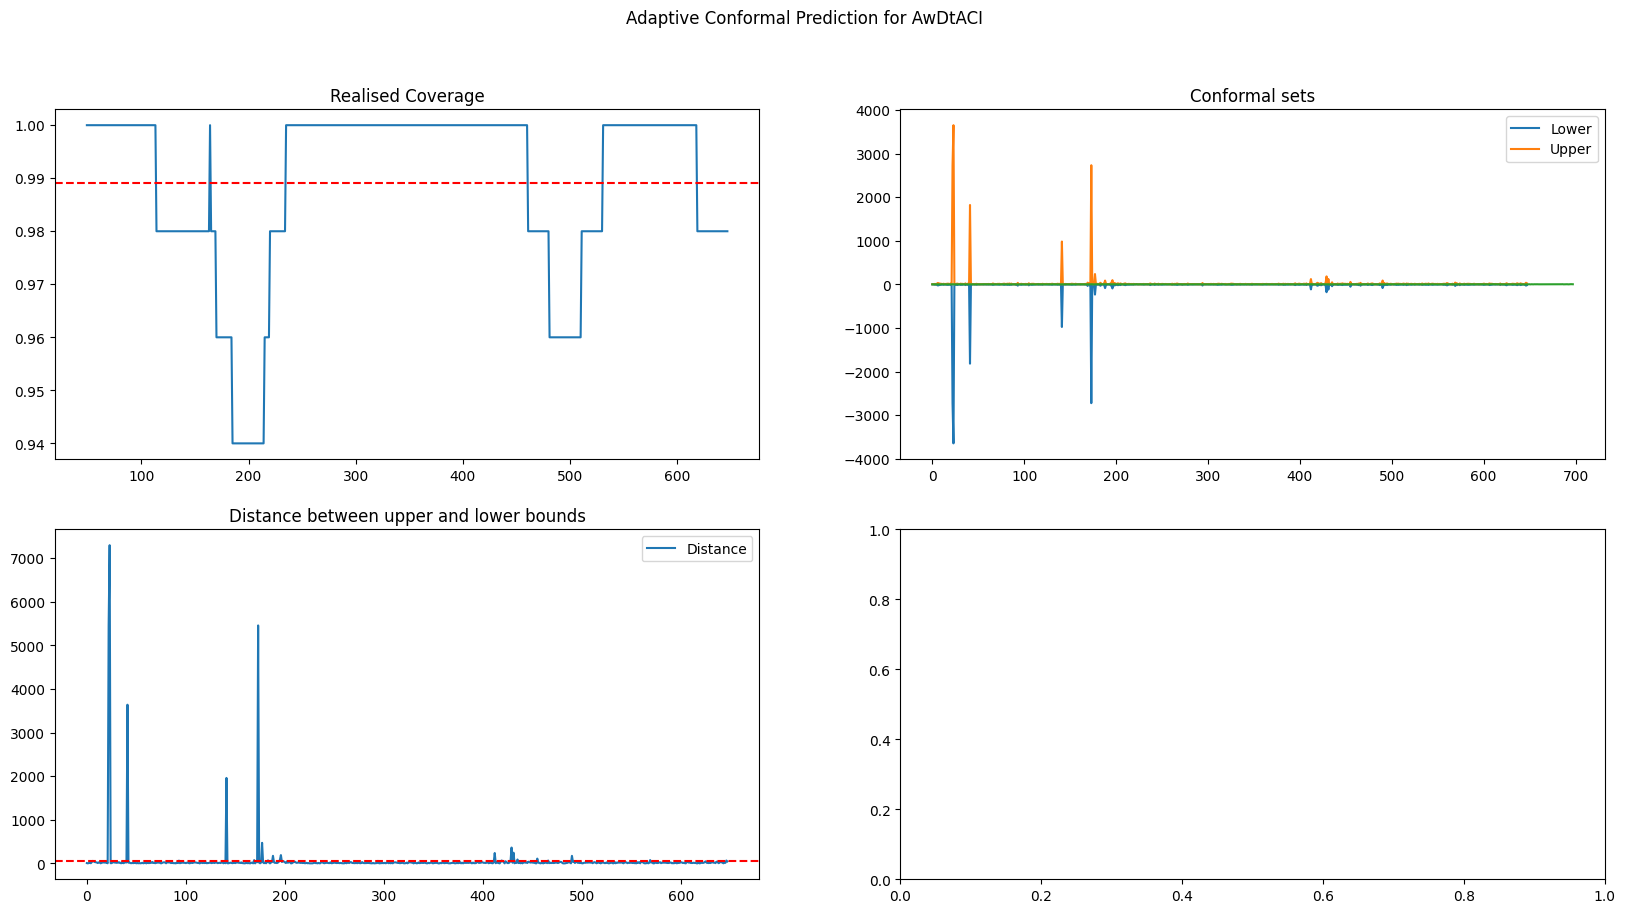

In [111]:
ACP = AdaptiveCP(0.3)
ACP_plots.compare_many([result, ACP.ACI(single_shift, 0.05)])
ACP_plots.one_plot(result, single_shift[1])

# Testting the best possible case for AwDtAci

Here we will look into how AwDtAci would perform if it could choose the best head at each point. Hence we will run multiple DtACI heads in parrelel, then after look at what the best coverage is, hence taking the lowest coverage at each point.

In [7]:
single_shift = ACP_data.single_shift(seq_length=750)[0]

In [12]:
ACP = AdaptiveCP(0.3)
heads = [ACP.DtACI(single_shift, custom_interval=interval)['error_t_list'][200-interval:] for interval in range(25, 200, 25)]

In [14]:
heads.pop(0)
print([len(head) for head in heads])

[548, 548, 548, 548, 548, 548]


In [40]:
coverage_strings = [0.3 - pd.Series(head).rolling(50).mean().dropna().to_numpy() for head in heads]

In [47]:
zipped = list(zip(*coverage_strings))
best = [min([abs(x) for x in zip_round]) for zip_round in zipped]
print('The best possible version would have: ', 0.7 + np.mean(best))
print('The minimum standard deviation would be: ', np.std(best))

The best possible version would have:  0.7088577154308616
The minimum standard deviation would be:  0.013786876060013404


Combining all into a funciton.

In [50]:
def Best_Result(data, target):
    heads = [ACP.DtACI(data, custom_interval=interval)['error_t_list'][200-interval:] for interval in range(25, 200, 25)]
    heads.pop(0)
    coverage_strings = [target - pd.Series(head).rolling(50).mean().dropna().to_numpy() for head in heads]
    zipped = list(zip(*coverage_strings))
    best = [min([abs(x) for x in zip_round]) for zip_round in zipped]
    print('The best possible version would have: ', 1 - target + np.mean(best))
    print('The minimum standard deviation would be: ', np.std(best))

In [52]:
random_shift = ACP_data.random_multi_shift(1, (1000,1001))[0]
Best_Result(random_shift, 0.3)

The best possible version would have:  0.7186133333333333
The minimum standard deviation would be:  0.023781165283102135
